In [1]:
import numpy as np
import matplotlib.pyplot as plt
import dipy.reconst.dki as dki
import dipy.reconst.dti as dti
from dipy.core.gradients import gradient_table
from dipy.data import get_fnames
from dipy.io.gradients import read_bvals_bvecs
from dipy.io.image import load_nifti
from dipy.segment.mask import median_otsu
from scipy.ndimage import gaussian_filter

In [2]:
from os.path import expanduser, join
opt_dir = expanduser('/opt')
dname = join(opt_dir, 'dora', 'Dora','ELA','C-001','DTI_64_p2s3_kurtosis_b1000_2000','DTI_64_p2s3_kurtosis_b1000_2000')

fdwi_img = join(dname, 'DTI_64_p2s3_kurtosis_b1000_2000_DTI_64_p2s3_kurtosis_b1000_2000_20200217175212_8.nii')
print(fdwi_img)
fbval_img = join(dname, 'DTI_64_p2s3_kurtosis_b1000_2000_DTI_64_p2s3_kurtosis_b1000_2000_20200217175212_8.bval')
print(fbval_img)
fbvec_img = join(dname, 'DTI_64_p2s3_kurtosis_b1000_2000_DTI_64_p2s3_kurtosis_b1000_2000_20200217175212_8.bvec')
print(fbvec_img)

from dipy.io.image import load_nifti
data, affine, img = load_nifti(fdwi_img, return_img=True)

/opt/dora/Dora/ELA/C-001/DTI_64_p2s3_kurtosis_b1000_2000/DTI_64_p2s3_kurtosis_b1000_2000/DTI_64_p2s3_kurtosis_b1000_2000_DTI_64_p2s3_kurtosis_b1000_2000_20200217175212_8.nii
/opt/dora/Dora/ELA/C-001/DTI_64_p2s3_kurtosis_b1000_2000/DTI_64_p2s3_kurtosis_b1000_2000/DTI_64_p2s3_kurtosis_b1000_2000_DTI_64_p2s3_kurtosis_b1000_2000_20200217175212_8.bval
/opt/dora/Dora/ELA/C-001/DTI_64_p2s3_kurtosis_b1000_2000/DTI_64_p2s3_kurtosis_b1000_2000/DTI_64_p2s3_kurtosis_b1000_2000_DTI_64_p2s3_kurtosis_b1000_2000_20200217175212_8.bvec


In [3]:
from dipy.io import read_bvals_bvecs
bvals, bvecs = read_bvals_bvecs(fbval_img, fbvec_img)
from dipy.core.gradients import gradient_table
gtab = gradient_table(bvals, bvecs)

In [4]:
print(gtab.info)

B-values shape (140,)
         min 0.000000
         max 2000.000000
B-vectors shape (140, 3)
          min -0.999775
          max 0.997102

None


In [5]:
maskdata, mask = median_otsu(data, vol_idx=[0, 1], median_radius=4, numpass=2,
                             autocrop=False, dilate=1)

In [6]:
fwhm = 1.25
gauss_std = fwhm / np.sqrt(8 * np.log(2))  # converting fwhm to Gaussian std
data_smooth = np.zeros(data.shape)
for v in range(data.shape[-1]):
    data_smooth[..., v] = gaussian_filter(data[..., v], sigma=gauss_std)

In [7]:
dkimodel = dki.DiffusionKurtosisModel(gtab)

In [8]:
dkifit = dkimodel.fit(data_smooth, mask=mask)

In [9]:
FA = dkifit.fa
MD = dkifit.md
AD = dkifit.ad
RD = dkifit.rd

In [10]:
tenmodel = dti.TensorModel(gtab)
tenfit = tenmodel.fit(data_smooth, mask=mask)

dti_FA = tenfit.fa
dti_MD = tenfit.md
dti_AD = tenfit.ad
dti_RD = tenfit.rd

In [11]:
print(dti_FA[30,40])

[0.         0.         0.         0.         0.         0.
 0.         0.         0.07819145 0.09705638 0.09749676 0.04811158
 0.07837419 0.07177697 0.25322507 0.31598814 0.318387   0.3156939
 0.4119739  0.56592275 0.66100159 0.68856178 0.70782465 0.71217107
 0.64913617 0.54773215 0.48246555 0.43509337 0.43402696 0.3688109
 0.41102102 0.4426886  0.39475636 0.34234385 0.31827036 0.27681193
 0.37164224 0.45965007 0.46557712 0.45408813 0.42178384 0.43517776
 0.45179067 0.29201234 0.11286489 0.03559346 0.04911619 0.06955451
 0.07716286 0.07591861 0.06368866 0.0661351  0.05295152 0.07123334
 0.08448071 0.06720496 0.08045951 0.20070513 0.         0.
 0.         0.         0.         0.         0.         0.        ]


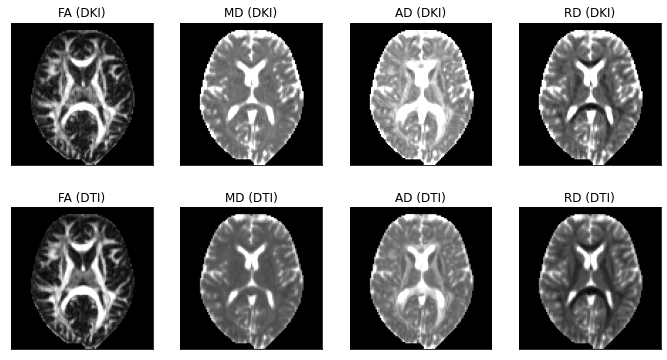

In [12]:
axial_slice = 30

fig1, ax = plt.subplots(2, 4, figsize=(12, 6),
                        subplot_kw={'xticks': [], 'yticks': []})

fig1.subplots_adjust(hspace=0.3, wspace=0.05)

ax.flat[0].imshow(FA[:, :, axial_slice].T, cmap='gray',
                  vmin=0, vmax=0.7, origin='lower')
ax.flat[0].set_title('FA (DKI)')
ax.flat[1].imshow(MD[:, :, axial_slice].T, cmap='gray',
                  vmin=0, vmax=2.0e-3, origin='lower')
ax.flat[1].set_title('MD (DKI)')
ax.flat[2].imshow(AD[:, :, axial_slice].T, cmap='gray',
                  vmin=0, vmax=2.0e-3, origin='lower')
ax.flat[2].set_title('AD (DKI)')
ax.flat[3].imshow(RD[:, :, axial_slice].T, cmap='gray',
                  vmin=0, vmax=2.0e-3, origin='lower')
ax.flat[3].set_title('RD (DKI)')

ax.flat[4].imshow(dti_FA[:, :, axial_slice].T, cmap='gray',
                  vmin=0, vmax=0.7, origin='lower')
ax.flat[4].set_title('FA (DTI)')
ax.flat[5].imshow(dti_MD[:, :, axial_slice].T, cmap='gray',
                  vmin=0, vmax=2.0e-3, origin='lower')
ax.flat[5].set_title('MD (DTI)')
ax.flat[6].imshow(dti_AD[:, :, axial_slice].T, cmap='gray',
                  vmin=0, vmax=2.0e-3, origin='lower')
ax.flat[6].set_title('AD (DTI)')
ax.flat[7].imshow(dti_RD[:, :, axial_slice].T, cmap='gray',
                  vmin=0, vmax=2.0e-3, origin='lower')
ax.flat[7].set_title('RD (DTI)')

plt.show()
fig1.savefig('Diffusion_tensor_measures_from_DTI_and_DKI.png')

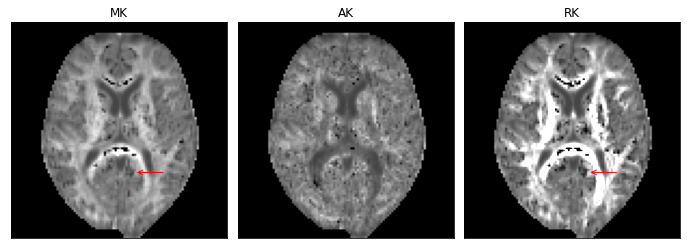

In [13]:
MK = dkifit.mk(0, 3)
AK = dkifit.ak(0, 3)
RK = dkifit.rk(0, 3)
fig2, ax = plt.subplots(1, 3, figsize=(12, 6),
                        subplot_kw={'xticks': [], 'yticks': []})

fig2.subplots_adjust(hspace=0.3, wspace=0.05)

ax.flat[0].imshow(MK[:, :, axial_slice].T, cmap='gray', vmin=0, vmax=1.5,
                  origin='lower')
ax.flat[0].set_title('MK')
ax.flat[0].annotate('', fontsize=12, xy=(57, 30),
                    color='red',
                    xycoords='data', xytext=(30, 0),
                    textcoords='offset points',
                    arrowprops=dict(arrowstyle="->",
                                    color='red'))
ax.flat[1].imshow(AK[:, :, axial_slice].T, cmap='gray', vmin=0, vmax=1.5,
                  origin='lower')
ax.flat[1].set_title('AK')
ax.flat[2].imshow(RK[:, :, axial_slice].T, cmap='gray', vmin=0, vmax=1.5,
                  origin='lower')
ax.flat[2].set_title('RK')
ax.flat[2].annotate('', fontsize=12, xy=(57, 30),
                    color='red',
                    xycoords='data', xytext=(30, 0),
                    textcoords='offset points',
                    arrowprops=dict(arrowstyle="->",
                                    color='red'))

plt.show()
fig2.savefig('Kurtosis_tensor_standard_measures.png')

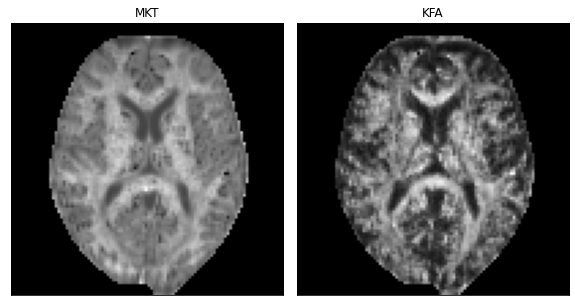

In [14]:
MKT = dkifit.mkt(0, 3)
KFA = dkifit.kfa

fig3, ax = plt.subplots(1, 2, figsize=(10, 6),
                        subplot_kw={'xticks': [], 'yticks': []})

fig3.subplots_adjust(hspace=0.3, wspace=0.05)

ax.flat[0].imshow(MKT[:, :, axial_slice].T, cmap='gray', vmin=0, vmax=1.5,
                  origin='lower')
ax.flat[0].set_title('MKT')
ax.flat[1].imshow(KFA[:, :, axial_slice].T, cmap='gray', vmin=0, vmax=1,
                  origin='lower')
ax.flat[1].set_title('KFA')

plt.show()
fig3.savefig('Measures_from_kurtosis_tensor_only.png')

In [15]:
import os.path as op
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
import dipy.data as dpd
from dipy.data import fetcher
from dipy.io.streamline import save_tractogram, load_tractogram
from dipy.stats.analysis import afq_profile, gaussian_weights
from dipy.io.stateful_tractogram import StatefulTractogram
from dipy.io.stateful_tractogram import Space
from dipy.align import affine_registration

import AFQ.api.bundle_dict as abd
import AFQ.data.fetch as afd
import AFQ.tractography as aft
import AFQ.registration as reg
import AFQ.models.dti as dti
import AFQ.segmentation as seg
from AFQ.utils.volume import transform_inverse_roi

import logging
logging.basicConfig(level=logging.INFO)

# Target directory for this example's output files
working_dir = "./tract_profile"

In [16]:
opt_dir = expanduser('/opt')
dname = join(opt_dir, 'dora', 'Dora','ELA','P-003','DTI_64_p2s3_kurtosis_b1000_2000','DTI_64_p2s3_kurtosis_b1000_2000')

hardi_fdata = op.join(dname, 'DTI_64_p2s3_kurtosis_b1000_2000_DTI_64_p2s3_kurtosis_b1000_2000_20200120171342_8.nii')
print(hardi_fdata)
hardi_fbval = op.join(dname, 'DTI_64_p2s3_kurtosis_b1000_2000_DTI_64_p2s3_kurtosis_b1000_2000_20200120171342_8.bval')
print(hardi_fbval)
hardi_fbvec = op.join(dname, 'DTI_64_p2s3_kurtosis_b1000_2000_DTI_64_p2s3_kurtosis_b1000_2000_20200120171342_8.bvec')
print(hardi_fbvec)

img = nib.load(hardi_fdata)

# from dipy.io.image import load_nifti
# data, affine, img2 = load_nifti(fdwi_img, return_img=True)
# print(img2)

/opt/dora/Dora/ELA/P-003/DTI_64_p2s3_kurtosis_b1000_2000/DTI_64_p2s3_kurtosis_b1000_2000/DTI_64_p2s3_kurtosis_b1000_2000_DTI_64_p2s3_kurtosis_b1000_2000_20200120171342_8.nii
/opt/dora/Dora/ELA/P-003/DTI_64_p2s3_kurtosis_b1000_2000/DTI_64_p2s3_kurtosis_b1000_2000/DTI_64_p2s3_kurtosis_b1000_2000_DTI_64_p2s3_kurtosis_b1000_2000_20200120171342_8.bval
/opt/dora/Dora/ELA/P-003/DTI_64_p2s3_kurtosis_b1000_2000/DTI_64_p2s3_kurtosis_b1000_2000/DTI_64_p2s3_kurtosis_b1000_2000_DTI_64_p2s3_kurtosis_b1000_2000_20200120171342_8.bvec


In [17]:
print("Calculating DTI...")
if not op.exists(op.join(working_dir, 'dti_FA.nii.gz')):
    dti_params = dti.fit_dti(hardi_fdata, hardi_fbval, hardi_fbvec,
                             out_dir=working_dir)
else:
    dti_params = {'FA': op.join(working_dir, 'dti_FA.nii.gz'),
                  'params': op.join(working_dir, 'dti_params.nii.gz')}

FA_img = nib.load(dti_params['FA'])
FA_data = FA_img.get_fdata()

Calculating DTI...


In [18]:
print("Registering to template...")
MNI_T2_img = afd.read_mni_template()

if not op.exists(op.join(working_dir, 'mapping.nii.gz')):
    import dipy.core.gradients as dpg
    gtab = dpg.gradient_table(hardi_fbval, hardi_fbvec)
    b0 = np.mean(img.get_fdata()[..., gtab.b0s_mask], -1)
    # Prealign using affine registration
    _, prealign = affine_registration(
        b0,
        MNI_T2_img.get_fdata(),
        img.affine,
        MNI_T2_img.affine)

    # Then register using a non-linear registration using the affine for
    # prealignment
    warped_hardi, mapping = reg.syn_register_dwi(hardi_fdata, gtab,
                                                 prealign=prealign)
    reg.write_mapping(mapping, op.join(working_dir, 'mapping.nii.gz'))
else:
    mapping = reg.read_mapping(op.join(working_dir, 'mapping.nii.gz'),
                               img, MNI_T2_img)

Registering to template...


In [19]:
bundles = abd.BundleDict(
    ["CST_L", "CST_R", "ARC_L", "ARC_R"],
    resample_to=MNI_T2_img)

In [20]:
print("Tracking...")
if not op.exists(op.join(working_dir, 'dti_streamlines.trk')):
    seed_roi = np.zeros(img.shape[:-1])
    for bundle in bundles:
        for idx, roi in enumerate(bundles[bundle]['include']):
            warped_roi = transform_inverse_roi(
                roi,
                mapping,
                bundle_name=bundle)

            nib.save(
                nib.Nifti1Image(warped_roi.astype(float), img.affine),
                op.join(working_dir, f"{bundle}_{idx+1}.nii.gz"))
            # Add voxels that aren't there yet:
            seed_roi = np.logical_or(seed_roi, warped_roi)
    nib.save(nib.Nifti1Image(
        seed_roi.astype(float), img.affine),
        op.join(working_dir, 'seed_roi.nii.gz'))
    sft = aft.track(dti_params['params'], seed_mask=seed_roi,
                    stop_mask=FA_data, stop_threshold=0.1,
                    directions="det", odf_model="dti")
    save_tractogram(sft, op.join(working_dir, 'dti_streamlines.trk'),
                    bbox_valid_check=False)
else:
    sft = load_tractogram(op.join(working_dir, 'dti_streamlines.trk'), img)

sft.to_vox()

ERROR:root:Affine not equal
ERROR:root:Trk file header does not match the provided reference.


Tracking...


AttributeError: 'bool' object has no attribute 'to_vox'

In [33]:
print("Segmenting fiber groups...")
segmentation = seg.Segmentation(return_idx=True)
segmentation.segment(bundles,
                     sft,
                     fdata=hardi_fdata,
                     fbval=hardi_fbval,
                     fbvec=hardi_fbvec,
                     mapping=mapping,
                     reg_template=MNI_T2_img)

fiber_groups = segmentation.fiber_groups

Segmenting fiber groups...


  0%|          | 0/285 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/381 [00:00<?, ?it/s]

In [34]:
print("Cleaning fiber groups...")
for bundle in bundles:
    print(f"Cleaning {bundle}")
    print(f"Before cleaning: {len(fiber_groups[bundle]['sl'])} streamlines")
    new_fibers, idx_in_bundle = seg.clean_bundle(
        fiber_groups[bundle]['sl'],
        return_idx=True)
    print(f"Afer cleaning: {len(new_fibers)} streamlines")

    idx_in_global = fiber_groups[bundle]['idx'][idx_in_bundle]
    np.save(op.join(working_dir, f'{bundle}_idx.npy'), idx_in_global)
    sft = StatefulTractogram(new_fibers.streamlines,
                             img,
                             Space.VOX)
    sft.to_rasmm()
    save_tractogram(sft, op.join(working_dir, f'{bundle}_afq.trk'),
                    bbox_valid_check=False)

Cleaning fiber groups...
Cleaning CST_L
Before cleaning: 5 streamlines
Afer cleaning: 5 streamlines
Cleaning CST_R
Before cleaning: 11 streamlines
Afer cleaning: 11 streamlines
Cleaning ARC_L
Before cleaning: 12 streamlines
Afer cleaning: 12 streamlines
Cleaning ARC_R
Before cleaning: 2 streamlines
Afer cleaning: 2 streamlines


Extracting tract profiles...


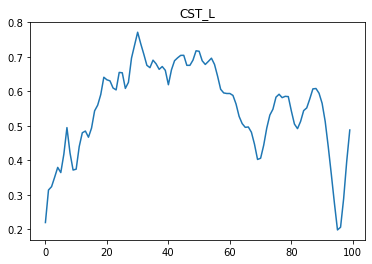

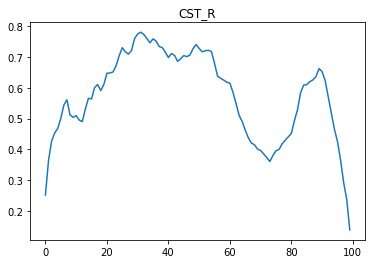

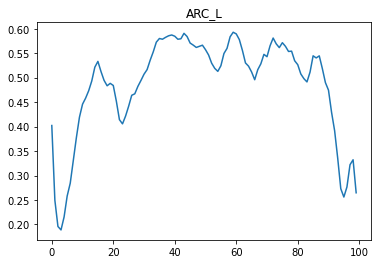

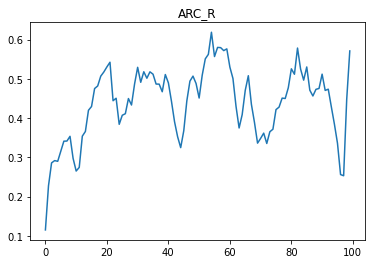

In [35]:
print("Extracting tract profiles...")
for bundle in bundles:
    sft = load_tractogram(op.join(working_dir, f'{bundle}_afq.trk'),
                          img, to_space=Space.VOX)
    fig, ax = plt.subplots(1)
    weights = gaussian_weights(sft.streamlines)
    profile = afq_profile(FA_data, sft.streamlines,
                          np.eye(4), weights=weights)
    ax.plot(profile)
    ax.set_title(bundle)

plt.show()